In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from econml.grf import CausalForest
from sklift.metrics import qini_curve, qini_auc_score, uplift_curve
from sklift.viz import plot_uplift_curve, plot_qini_curve, plot_uplift_by_percentile
# from upliftml.evaluation import estimate_and_plot_cate_lift, estimate_and_plot_qini

from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)
print(data.shape)
print(data.columns)
data

(3941, 27)
Index(['id', 'mort_28', 'age', 'sex', 'weight', 'height', 'pf_ratio', 'po2',
       'pco2', 'ph', 'driving_pressure', 'lung_compliance', 'map', 'bilirubin',
       'creatinine', 'platelets', 'urea', 'fio2', 'hco3', 'heart_rate',
       'minute_volume', 'peep', 'plateau_pressure', 'respiratory_rate',
       'syst_blood_pressure', 'diastolic_blood_pressure', 'peep_regime'],
      dtype='object')


,id,mort_28,age,sex,weight,height,pf_ratio,po2,pco2,ph,...,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,peep_regime
0,32128372,False,75,F,93.0,168.0,241.944444,130.666667,28.111111,7.245556,...,50.000000,12.000000,115.408163,8.241111,8.777778,24.333333,18.943662,100.600000,68.200000,low
1,34100191,False,47,M,127.0,183.0,166.356061,113.076923,34.461538,7.196923,...,68.500000,12.750000,115.407407,16.628571,7.375000,17.500000,19.857143,99.000000,68.000000,low
2,38292466,False,85,M,77.5,170.0,224.000000,112.000000,38.000000,7.440000,...,51.818182,23.000000,70.041667,9.433333,5.000000,22.333333,15.833333,102.000000,46.333333,low
3,32743332,False,85,M,90.7,170.0,205.714286,72.000000,38.000000,7.500000,...,36.875000,27.000000,70.480000,7.478571,5.000000,24.000000,18.200000,108.083333,46.208333,low
4,35009126,True,64,M,70.0,183.0,173.777778,94.666667,38.666667,7.400000,...,52.500000,21.666667,73.955556,7.050000,5.428571,14.328571,15.016667,103.415094,57.377358,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,32959861,True,78,F,57.0,160.0,157.178571,136.833333,38.083333,7.370833,...,65.454545,22.000000,95.785714,8.511111,6.800000,22.000000,16.677419,NaN,NaN,low
3937,32761676,False,75,M,101.0,178.0,179.909091,91.714286,39.000000,7.310000,...,52.142857,17.600000,60.394737,7.250000,5.000000,15.400000,16.795455,NaN,NaN,low
3938,34058245,True,67,F,100.0,165.0,158.331733,104.250000,43.250000,7.292500,...,77.142857,18.800000,122.041667,8.813333,16.700000,30.333333,25.290323,101.789474,59.631579,high
3939,34670930,False,68,M,94.7,163.0,192.500000,90.600000,40.400000,7.414000,...,60.000000,23.500000,65.807692,8.816667,9.166667,21.285714,21.531250,158.000000,83.500000,low


In [3]:
xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 1 if x == False else 0, y))

xs = xs.drop(columns=["id", "mort_28", "peep", "peep_regime"])
columns_x = xs.columns

xs.loc[xs["sex"] == "M", "sex"] = 0
xs.loc[xs["sex"] == "F", "sex"] = 1

xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,75,1,93.0,168.0,241.944444,130.666667,28.111111,7.245556,11.000000,31.227273,...,83.000000,3.71280,50.000000,12.000000,115.408163,8.241111,24.333333,18.943662,100.600000,68.200000
1,47,0,127.0,183.0,166.356061,113.076923,34.461538,7.196923,8.350000,79.780702,...,19.600000,32.21925,68.500000,12.750000,115.407407,16.628571,17.500000,19.857143,99.000000,68.000000
2,85,0,77.5,170.0,224.000000,112.000000,38.000000,7.440000,17.250000,33.338235,...,124.500000,16.42200,51.818182,23.000000,70.041667,9.433333,22.333333,15.833333,102.000000,46.333333
3,85,0,90.7,170.0,205.714286,72.000000,38.000000,7.500000,17.000000,26.882353,...,200.000000,24.63300,36.875000,27.000000,70.480000,7.478571,24.000000,18.200000,108.083333,46.208333
4,64,0,70.0,183.0,173.777778,94.666667,38.666667,7.400000,8.585714,52.821226,...,513.666667,5.11700,52.500000,21.666667,73.955556,7.050000,14.328571,15.016667,103.415094,57.377358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,78,1,57.0,160.0,157.178571,136.833333,38.083333,7.370833,16.400000,26.829268,...,209.666667,14.63700,65.454545,22.000000,95.785714,8.511111,22.000000,16.677419,NaN,NaN
3937,75,0,101.0,178.0,179.909091,91.714286,39.000000,7.310000,10.400000,42.412137,...,78.200000,28.70280,52.142857,17.600000,60.394737,7.250000,15.400000,16.795455,NaN,NaN
3938,67,1,100.0,165.0,158.331733,104.250000,43.250000,7.292500,13.200000,25.796667,...,309.400000,15.06540,77.142857,18.800000,122.041667,8.813333,30.333333,25.290323,101.789474,59.631579
3939,68,0,94.7,163.0,192.500000,90.600000,40.400000,7.414000,12.500000,33.805421,...,151.200000,6.69375,60.000000,23.500000,65.807692,8.816667,21.285714,21.531250,158.000000,83.500000


In [4]:
xs.describe()

,age,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,map,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
count,3941.000000,3939.000000,3374.000000,3610.000000,3792.000000,3794.000000,3794.000000,3279.000000,3259.000000,3237.000000,...,3924.000000,3936.000000,3859.000000,3935.000000,3941.000000,3741.000000,3608.000000,3941.000000,3241.000000,3239.000000
mean,63.191322,87.955657,169.400759,245.209237,133.270432,41.917010,7.345282,12.241982,42.172437,74.684663,...,197.416450,10.837012,57.893765,22.028731,89.136033,9.516279,20.698614,20.693890,112.103027,62.615542
std,16.110703,27.438546,11.347380,123.787407,52.375877,9.704451,0.081361,3.409175,18.840383,12.040751,...,109.101730,7.937028,13.975565,5.154144,17.818686,2.345188,5.153424,4.202464,17.031672,12.019379
min,18.000000,20.000000,64.000000,26.000000,25.000000,16.444444,6.999231,0.000000,5.726872,28.500000,...,8.000000,0.357000,10.000000,8.000000,45.012195,1.275000,0.000000,4.142857,49.000000,23.250000
25%,53.000000,69.400000,163.000000,160.000000,95.500000,35.750000,7.294325,10.000000,31.524536,67.000000,...,122.468750,5.622750,48.125000,18.666667,76.153846,7.883333,17.000000,17.628571,101.000000,54.671171
50%,65.000000,84.000000,170.000000,225.559524,121.071429,40.250000,7.347361,12.000000,39.155213,73.160000,...,178.690476,8.389500,55.555556,21.750000,87.625000,9.240000,20.200000,20.181818,109.350000,61.600000
75%,75.000000,101.700000,178.000000,302.500000,159.287582,45.854396,7.400000,14.200000,48.711688,81.000000,...,247.233333,13.494600,66.250000,25.000000,101.416667,10.887500,23.800000,23.357143,121.083333,69.020000
max,98.000000,296.800000,203.000000,1660.000000,472.000000,112.000000,7.700000,50.250000,314.500000,142.000000,...,1144.500000,70.839000,100.000000,47.000000,161.441860,25.475000,115.000000,37.500000,189.888889,132.000000


In [4]:
norm_xs = (xs - xs.mean())/xs.std()
norm_xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,0.732971,1.191182,0.183841,-0.123443,-0.026374,-0.049713,-1.422636,-1.225725,-0.364306,-0.580942,...,-1.048713,-0.897592,-0.564826,-1.945761,1.474415,-0.543738,0.705302,-0.416477,-0.67539,0.464621
1,-1.005004,-0.839289,1.422974,1.198448,-0.637005,-0.38555,-0.768253,-1.823462,-1.14162,1.996152,...,-1.629822,2.693985,0.758913,-1.800247,1.474372,3.032717,-0.620678,-0.199109,-0.769333,0.447981
2,1.353676,-0.839289,-0.381057,0.052809,-0.171336,-0.406111,-0.40363,1.164175,1.468983,-0.468897,...,-0.668334,0.703662,-0.434729,0.188444,-1.071592,-0.035368,0.31721,-1.156597,-0.593191,-1.354663
3,1.353676,-0.839289,0.100018,0.052809,-0.319055,-1.169822,-0.40363,1.901629,1.395651,-0.811559,...,0.02368,1.738181,-1.503965,0.964519,-1.046993,-0.868889,0.64062,-0.593435,-0.236013,-1.365063
4,0.050195,-0.839289,-0.654395,1.198448,-0.577049,-0.737052,-0.334933,0.672538,-1.072479,0.565211,...,2.898673,-0.720674,-0.385943,-0.070247,-0.851941,-1.051634,-1.23608,-1.350927,-0.510105,-0.435811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,1.191182,-1.128181,-0.828452,-0.711144,0.068026,-0.395043,0.314053,1.219655,-0.814377,...,0.112283,0.478767,0.541,-0.005574,0.373186,-0.428608,0.252528,-0.955742,NaN,NaN
3937,0.732971,-0.839289,0.475402,0.757817,-0.527518,-0.793421,-0.300585,-0.433644,-0.540301,0.012723,...,-1.092709,2.250942,-0.411497,-0.859256,-1.612986,-0.966353,-1.028174,-0.927655,NaN,NaN
3938,0.236407,1.191182,0.438957,-0.387822,-0.701828,-0.55408,0.137359,-0.648735,0.281012,-0.869185,...,1.026414,0.532742,1.377339,-0.626434,1.846693,-0.299739,1.869576,1.093747,-0.605551,-0.248263
3939,0.298477,-0.839289,0.245798,-0.564074,-0.425805,-0.814696,-0.156321,0.844611,0.075683,-0.4441,...,-0.423609,-0.522017,0.150708,0.285454,-1.309207,-0.298318,0.113924,0.199255,2.694801,1.737565


In [5]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imp_xs = imputer.fit_transform(norm_xs)

imp_xs = pd.DataFrame(data=imp_xs, columns=columns_x)

imp_xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,0.732971,1.191182,0.183841,-0.123443,-0.026374,-0.049713,-1.422636,-1.225725,-0.364306,-0.580942,...,-1.048713,-0.897592,-0.564826,-1.945761,1.474415,-0.543738,0.705302,-0.416477,-0.675390,0.464621
1,-1.005004,-0.839289,1.422974,1.198448,-0.637005,-0.385550,-0.768253,-1.823462,-1.141620,1.996152,...,-1.629822,2.693985,0.758913,-1.800247,1.474372,3.032717,-0.620678,-0.199109,-0.769333,0.447981
2,1.353676,-0.839289,-0.381057,0.052809,-0.171336,-0.406111,-0.403630,1.164175,1.468983,-0.468897,...,-0.668334,0.703662,-0.434729,0.188444,-1.071592,-0.035368,0.317210,-1.156597,-0.593191,-1.354663
3,1.353676,-0.839289,0.100018,0.052809,-0.319055,-1.169822,-0.403630,1.901629,1.395651,-0.811559,...,0.023680,1.738181,-1.503965,0.964519,-1.046993,-0.868889,0.640620,-0.593435,-0.236013,-1.365063
4,0.050195,-0.839289,-0.654395,1.198448,-0.577049,-0.737052,-0.334933,0.672538,-1.072479,0.565211,...,2.898673,-0.720674,-0.385943,-0.070247,-0.851941,-1.051634,-1.236080,-1.350927,-0.510105,-0.435811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,1.191182,-1.128181,-0.828452,-0.711144,0.068026,-0.395043,0.314053,1.219655,-0.814377,...,0.112283,0.478767,0.541000,-0.005574,0.373186,-0.428608,0.252528,-0.955742,-0.205677,-0.683525
3937,0.732971,-0.839289,0.475402,0.757817,-0.527518,-0.793421,-0.300585,-0.433644,-0.540301,0.012723,...,-1.092709,2.250942,-0.411497,-0.859256,-1.612986,-0.966353,-1.028174,-0.927655,-0.702715,-0.705604
3938,0.236407,1.191182,0.438957,-0.387822,-0.701828,-0.554080,0.137359,-0.648735,0.281012,-0.869185,...,1.026414,0.532742,1.377339,-0.626434,1.846693,-0.299739,1.869576,1.093747,-0.605551,-0.248263
3939,0.298477,-0.839289,0.245798,-0.564074,-0.425805,-0.814696,-0.156321,0.844611,0.075683,-0.444100,...,-0.423609,-0.522017,0.150708,0.285454,-1.309207,-0.298318,0.113924,0.199255,2.694801,1.737565


In [7]:
y

0       1
1       1
2       1
3       1
4       0
       ..
3936    0
3937    1
3938    0
3939    1
3940    0
Length: 3941, dtype: int64

In [54]:
# print(w.mean)
# w
np.mean(w)

0.12306521187515859

In [9]:
full_data = imp_xs.assign(W=w, Y=y)

causal_forest = CausalForest()
causal_forest.fit(full_data[columns_x], full_data["W"], full_data["Y"])
data_with_cate = full_data.assign(cate=causal_forest.predict(full_data[columns_x]))

In [10]:
data_with_cate["cate"].describe()

count    3941.000000
mean       -0.110364
std         0.079180
min        -0.445580
25%        -0.162250
50%        -0.102175
75%        -0.052527
max         0.115074
Name: cate, dtype: float64

In [11]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

In [12]:
full_data = imp_xs.assign(W=w, Y=y)

# train_x, test_x, train_w, test_w, train_y, test_y = train_test_split(imp_xs, w, y, test_size=0.3)
train, test = train_test_split(full_data, test_size=0.3)

invalid value encountered in scalar divide


Text(0.5, 1.0, 'Cumulative gain curve - Causal forest')

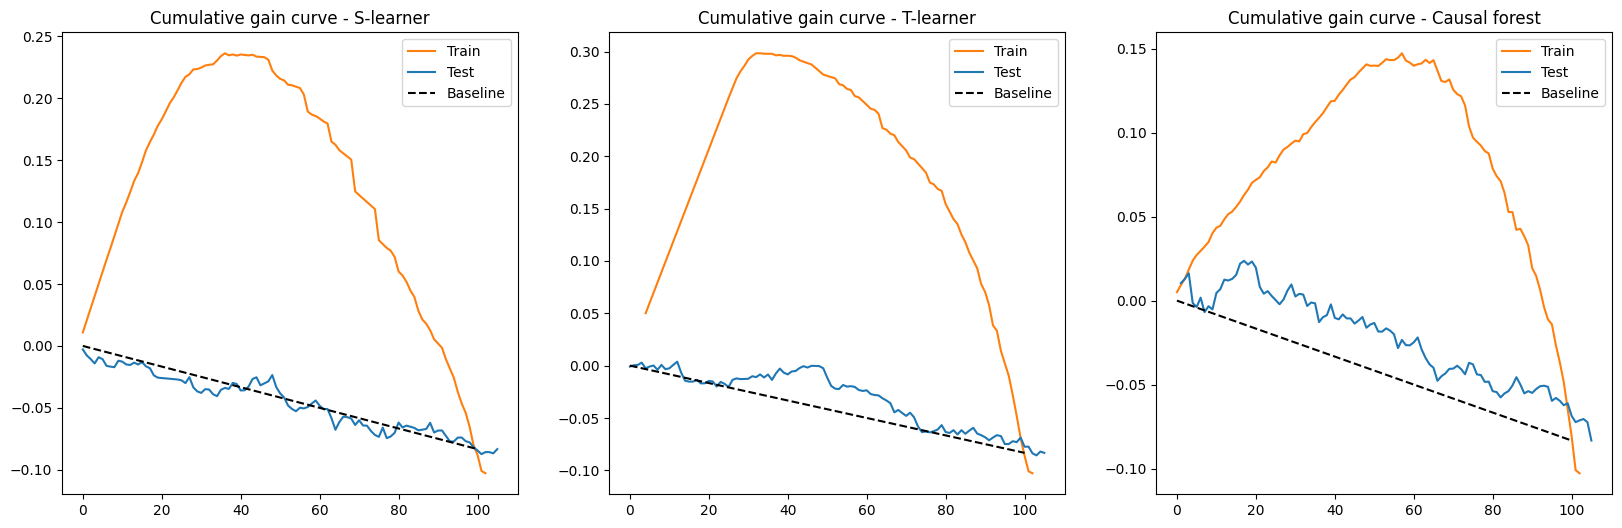

In [13]:
train_x = train[columns_x]
test_x = test[columns_x]

# S-learner
regr_s = RandomForestRegressor()
regr_s.fit(train.drop(columns=["Y"]), train["Y"])

# T-learner
regr0_t = RandomForestRegressor()
regr1_t = RandomForestRegressor()
regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

# Causal forest
cau_forest = CausalForest()
cau_forest.fit(train_x, train["W"], train["Y"])

# GET CATE

s_learner_cate_train = train.assign(cate=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})))
s_learner_cate_test = test.assign(cate=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})))

t_learner_cate_train = train.assign(cate=regr1_t.predict(train_x) - regr0_t.predict(train_x))
t_learner_cate_test = test.assign(cate=regr1_t.predict(test_x) - regr0_t.predict(test_x))

causal_forest_cate_train = train.assign(cate=cau_forest.predict(train_x))
causal_forest_cate_test = test.assign(cate=cau_forest.predict(test_x))

# causal_forest_cate_train = train_x.assign(cate=cau_forest.predict(train_x), W=train_w, Y=train_y)
# causal_forest_cate_test = test_x.assign(cate=cau_forest.predict(test_x), W=test_w, Y=test_y)

# GET GAIN CURVES

gain_curve_train_s = cumulative_gain(s_learner_cate_train, "cate", y="Y", t="W")
gain_curve_test_s = cumulative_gain(s_learner_cate_test, "cate", y="Y", t="W")

gain_curve_train_t = cumulative_gain(t_learner_cate_train, "cate", y="Y", t="W")
gain_curve_test_t = cumulative_gain(t_learner_cate_test, "cate", y="Y", t="W")

gain_curve_train_c_f = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
gain_curve_test_c_f = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")

# gain_curve_test = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")
# gain_curve_train = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

ax1.plot(gain_curve_train_s, color="C1", label="Train")
ax1.plot(gain_curve_test_s, color="C0", label="Test")
ax1.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
ax1.legend()
ax1.set_title("Cumulative gain curve - S-learner")

ax2.plot(gain_curve_train_t, color="C1", label="Train")
ax2.plot(gain_curve_test_t, color="C0", label="Test")
ax2.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
ax2.legend()
ax2.set_title("Cumulative gain curve - T-learner")

ax3.plot(gain_curve_train_c_f, color="C1", label="Train")
ax3.plot(gain_curve_test_c_f, color="C0", label="Test")
ax3.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
ax3.legend()
ax3.set_title("Cumulative gain curve - Causal forest")
# plt.plot(gain_curve_test, color="C0", label="Test")
# plt.plot(gain_curve_train, color="C1", label="Train")
# plt.plot([0, 100], [0, elast(test_x.assign(W=test_w, Y=test_y), "Y", "W")], linestyle="--", color="black", label="Baseline")
# plt.legend()
# plt.title("Cumulative gain curve")
# plt.show()

In [14]:
causal_forest_cate_test

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,W,Y,cate
770,-1.129145,1.191182,-1.397875,-0.960641,-1.484474,-0.904432,-0.990990,-1.294008,0.955662,-0.863836,...,-1.480116,0.216849,-0.021155,1.004456,1.584180,-0.743238,-0.166767,0,0,-0.149770
299,1.415747,-0.839289,-0.501326,0.317187,-0.783849,-0.829970,-0.238757,-0.286153,-0.804295,0.264555,...,-0.652303,1.013334,2.246914,1.125734,2.041383,-0.060247,-0.934402,1,0,-0.130442
27,1.229535,1.191182,-0.945956,-1.533460,-0.742335,0.827281,-0.493795,-0.256962,-0.305641,-0.818102,...,-0.393612,0.163279,-1.545654,-0.135563,-0.731285,-2.075723,-1.091200,0,1,-0.016747
642,-0.322228,1.191182,0.380645,-0.828452,-0.157039,-0.472936,-1.537131,-1.140371,-0.026981,-0.328501,...,-1.848751,0.081499,0.571751,-0.290800,0.534754,-1.356474,-1.582074,0,1,-0.202661
313,0.732971,1.191182,0.209353,-0.960641,-1.281606,-0.932526,-0.241702,-0.521436,1.065659,-0.668566,...,-0.296602,2.055887,-0.659341,1.300375,-0.222017,-1.053118,-0.767648,0,0,-0.182134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,0.422618,1.191182,-0.362835,-0.564074,-0.526784,-0.702049,-1.434085,0.918356,-0.364306,0.026229,...,-1.363705,-0.504408,0.248902,-0.678891,0.982671,1.285662,0.780777,0,0,-0.149653
459,0.484689,-0.839289,-0.063985,0.140935,-0.324825,-0.978894,0.214643,0.303811,0.808999,-0.292232,...,0.188444,-1.503656,-0.802897,-0.135563,-0.403071,1.595542,0.235362,0,1,-0.201443
1372,0.732971,1.191182,-0.217054,-0.123443,-0.938781,0.413286,-0.257649,-0.280007,-0.730963,1.136049,...,-0.490621,0.579476,-1.004729,-0.669189,-1.445152,1.017254,0.186499,0,1,-0.103597
3262,-2.432626,1.191182,-0.289945,0.405313,-1.328876,-1.069585,3.705309,-1.739553,0.149015,-0.548859,...,0.641154,2.163121,1.765685,0.485383,2.749841,-0.563833,-0.716804,0,1,-0.033545


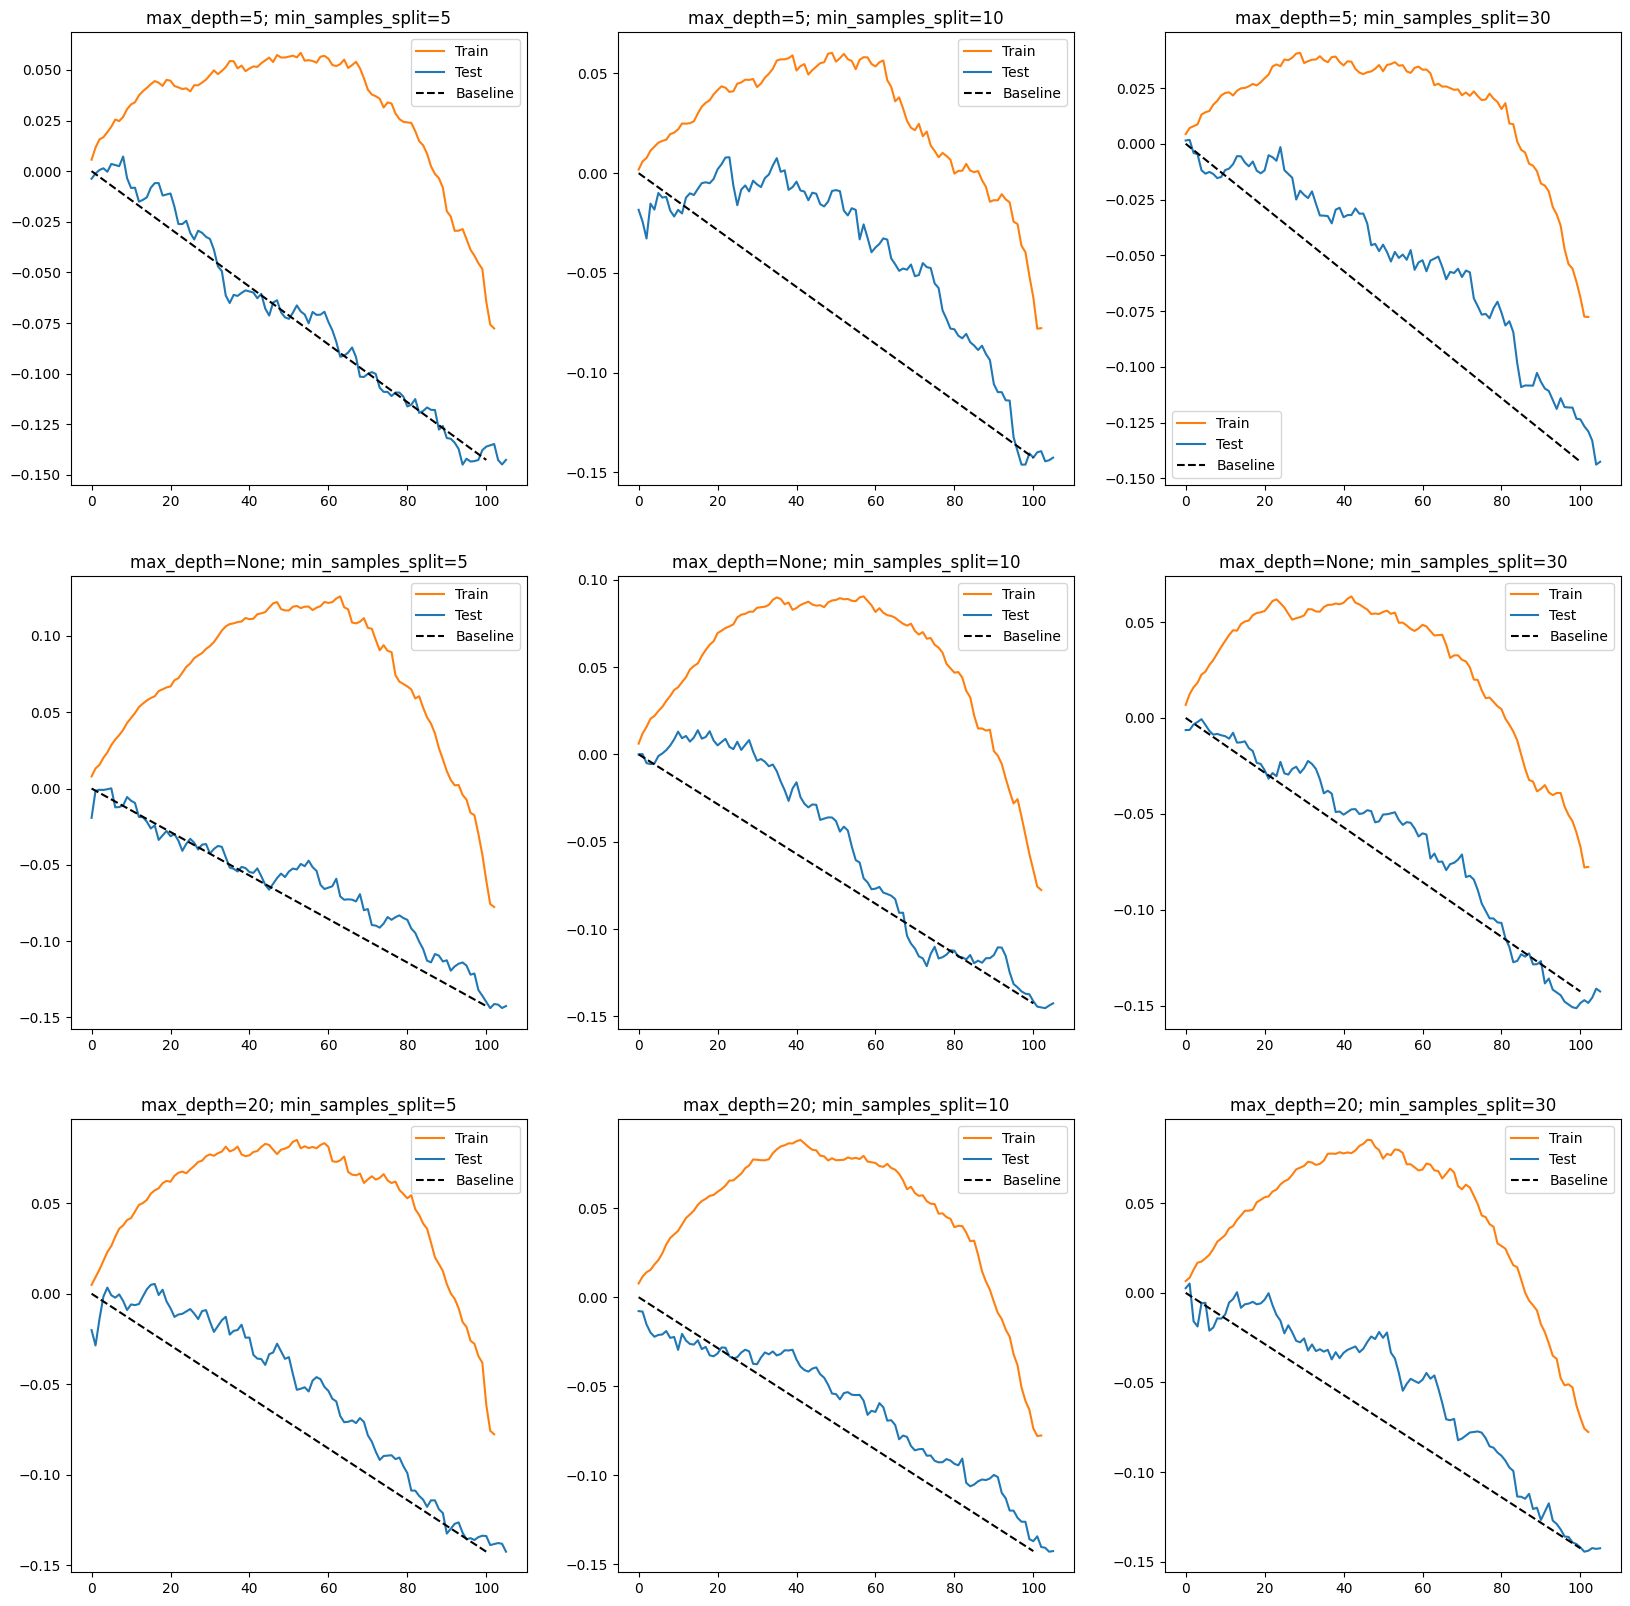

In [15]:
depths = [5, None, 20]
min_samples = [5, 10, 30]
fig, ax = plt.subplots(3, 3, figsize=(20,20))

train, test = train_test_split(full_data, test_size=0.3)

for i, dep in enumerate(depths):
    for j, m_s in enumerate(min_samples):
        cau_forest = CausalForest(max_depth=dep, min_samples_split=m_s)
        cau_forest.fit(train[columns_x], train["W"], train["Y"])

        causal_forest_cate_train = train.assign(cate=cau_forest.predict(train[columns_x]))
        causal_forest_cate_test = test.assign(cate=cau_forest.predict(test[columns_x]))

        gain_curve_train_c_f = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
        gain_curve_test_c_f = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")

        ax[i,j].plot(gain_curve_train_c_f, color="C1", label="Train")
        ax[i,j].plot(gain_curve_test_c_f, color="C0", label="Test")
        ax[i,j].plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
        ax[i,j].legend()
        ax[i,j].set_title(f"max_depth={dep}; min_samples_split={m_s}")

In [16]:
explainer = shap.Explainer(causal_forest)
shap_values = explainer(imp_xs)
shap_values


.values =
array([[-1.98933693e-02, -3.60047983e-05, -1.41494113e-02, ...,
         6.02101782e-03, -6.46417966e-03, -8.82176949e-04],
       [ 2.30206322e-02,  6.88277974e-04, -1.04071597e-02, ...,
        -1.48408129e-04, -1.65344333e-04, -1.35216282e-03],
       [-2.85815982e-02, -2.28195393e-04,  1.71664983e-03, ...,
         6.65248670e-03, -2.75505838e-03, -3.69269096e-03],
       ...,
       [ 5.54090040e-03, -1.18241698e-03, -1.25513681e-02, ...,
        -1.14074031e-03, -4.24689874e-03, -8.10159512e-04],
       [ 1.44568034e-02, -2.48174151e-04, -3.00151232e-03, ...,
        -2.91459385e-03,  6.61973664e-03,  3.71413695e-03],
       [ 1.08132356e-02, -6.41780987e-05, -5.10580921e-03, ...,
         5.15745645e-03, -6.57871469e-03, -5.45404895e-03]])

.base_values =
array([-0.0854832, -0.0854832, -0.0854832, ..., -0.0854832, -0.0854832,
       -0.0854832])

.data =
array([[ 0.73297099,  1.1911824 ,  0.18384149, ..., -0.41647661,
        -0.67539035,  0.46462117],
       [-1.00500

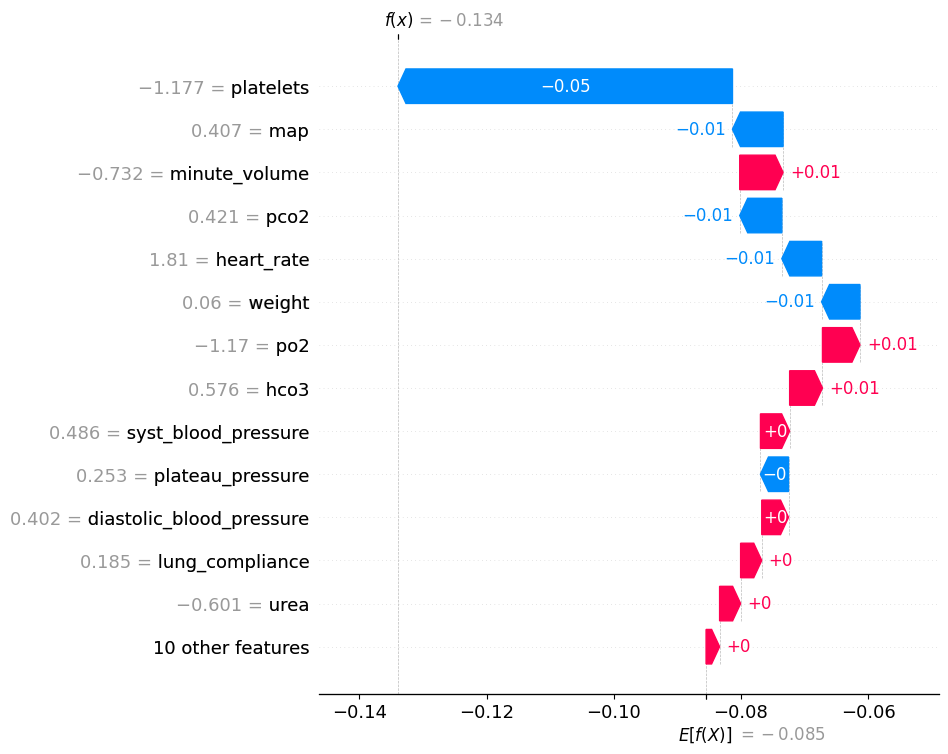

In [17]:
sample_ind = 20
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

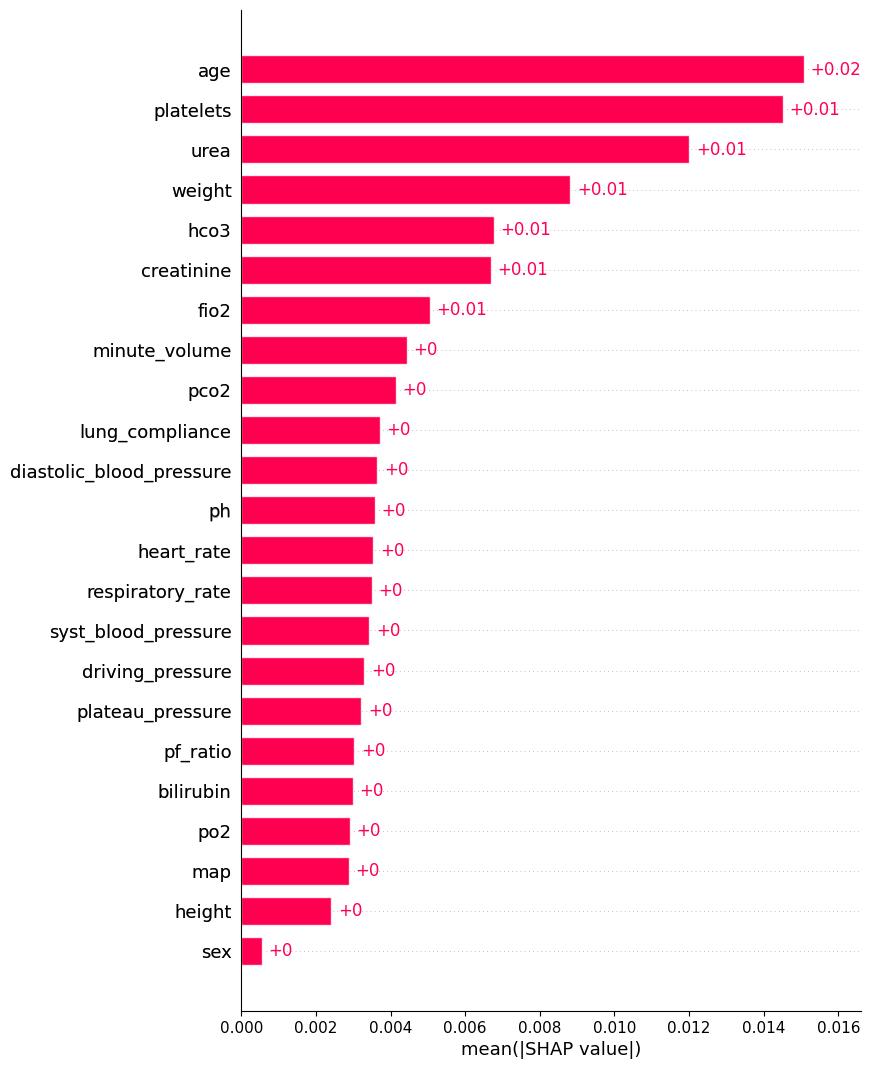

In [18]:
shap.plots.bar(shap_values, max_display=24)

In [7]:
full_data = imp_xs.assign(W=w, Y=y)

train, test = train_test_split(full_data, test_size=0.3)

In [19]:
train_x = train[columns_x]
test_x = test[columns_x]

# S-learner
regr_s = RandomForestRegressor()
regr_s.fit(train.drop(columns=["Y"]), train["Y"])

# T-learner
regr0_t = RandomForestRegressor()
regr1_t = RandomForestRegressor()
regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

# Causal forest
causal_forest = CausalForest()
causal_forest.fit(X=train_x, T=train["W"], y=train["Y"])

CausalForest()

In [9]:
uplift_curve(y_true=train["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list())

(array([   0,    1,    2, ..., 2756, 2757, 2758], dtype=int64),
 array([   0.        ,    1.        ,    0.        , ..., -243.61961962,
        -242.88850523, -243.30330222]))

In [30]:
list(regr1_t.predict(train_x) - regr0_t.predict(train_x))

[0.3,
 0.26,
 -0.25,
 -0.020000000000000018,
 0.19,
 -0.05999999999999994,
 0.53,
 -0.2300000000000001,
 -0.69,
 -0.12,
 0.25,
 0.19999999999999998,
 -0.2699999999999999,
 -0.35,
 -0.15000000000000002,
 -0.2799999999999999,
 -0.09999999999999998,
 -0.51,
 0.0,
 -0.33,
 0.51,
 -0.30000000000000004,
 -0.039999999999999925,
 -0.33999999999999997,
 0.38,
 0.12999999999999998,
 -0.14,
 -0.69,
 -0.27,
 -0.45,
 -0.42000000000000004,
 0.55,
 -0.35,
 -0.35,
 -0.16000000000000003,
 -0.45,
 -0.51,
 -0.43999999999999995,
 -0.26,
 -0.66,
 -0.18999999999999995,
 -0.2899999999999999,
 0.2,
 0.31999999999999995,
 -0.030000000000000027,
 0.54,
 -0.2899999999999999,
 -0.28,
 -0.08999999999999997,
 0.27,
 -0.040000000000000036,
 0.34,
 -0.39,
 -0.17000000000000004,
 -0.43999999999999995,
 -0.29999999999999993,
 -0.32999999999999996,
 -0.09000000000000008,
 -0.48000000000000004,
 -0.38999999999999996,
 -0.32999999999999996,
 -0.31,
 -0.37,
 -0.33000000000000007,
 0.29000000000000004,
 -0.35,
 -0.289999999

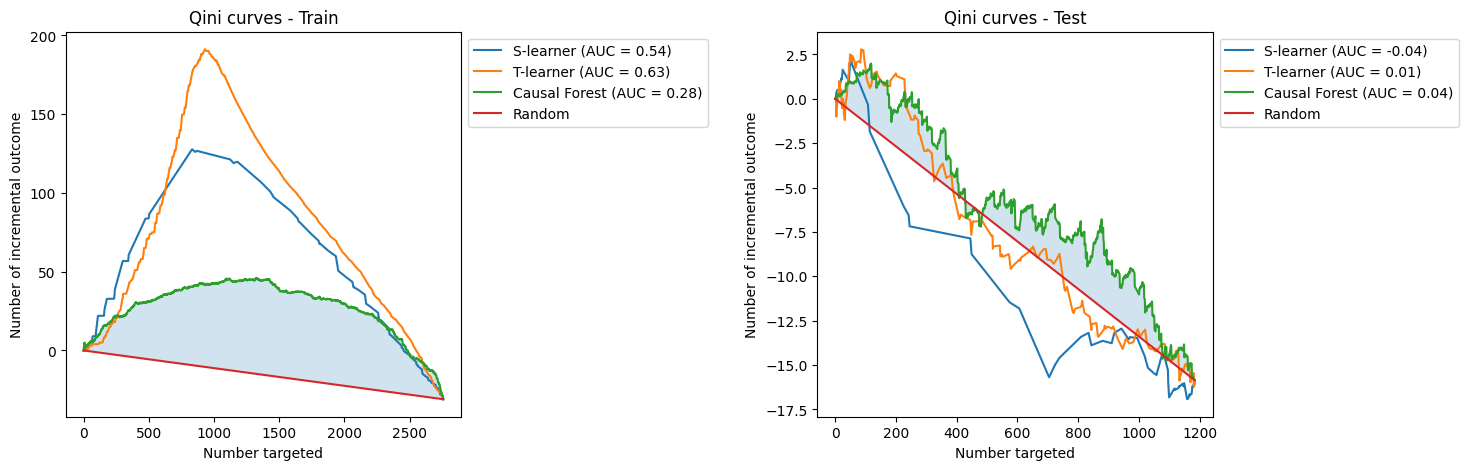

In [71]:
# orig size: (6.4, 4.8)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14.8, 5))
plt.subplots_adjust(wspace=0.9)
ax1.set_title('Qini curves - Train')
# print(fig.get_size_inches())

# plot_qini_curve(y_true=train["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list(), perfect=False, negative_effect=True, ax=ax)


plot_qini_curve(y_true=train["Y"].to_list(), uplift=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})), treatment=train["W"].to_list(), perfect=False, random=False, name="S-learner", ax=ax1)

plot_qini_curve(y_true=train["Y"].to_list(), uplift=(regr1_t.predict(train_x) - regr0_t.predict(train_x)).tolist(), treatment=train["W"].to_list(), perfect=False, random=False, name="T-learner", ax=ax1)

plot_qini_curve(y_true=train["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list(), perfect=False, name="Causal Forest", ax=ax1)

ax2.set_title('Qini curves - Test')

plot_qini_curve(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list(), perfect=False, random=False, name="S-learner", ax=ax2)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, random=False, name="T-learner", ax=ax2)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, name="Causal Forest", ax=ax2)

In [42]:
causal_forest.predict(train_x)

array([[-0.07984161],
       [-0.03959796],
       [-0.34895846],
       ...,
       [-0.09005398],
       [ 0.03716727],
       [-0.15904211]])

In [68]:
qini_auc_score(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list())

0.03560445447263979

# Qini AUC Tests

In [69]:
def run_qini_test(reps, full_data):

    score_s_train = []
    score_t_train = []
    score_forest_train = []

    score_s_test = []
    score_t_test = []
    score_forest_test = []

    for i in range(reps):
        train, test = train_test_split(full_data, test_size=0.3)

        train_x = train[columns_x]
        test_x = test[columns_x]

        # S-learner
        regr_s = RandomForestRegressor()
        regr_s.fit(train.drop(columns=["Y"]), train["Y"])

        # T-learner
        regr0_t = RandomForestRegressor()
        regr1_t = RandomForestRegressor()
        regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
        regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

        # Causal forest
        causal_forest = CausalForest()
        causal_forest.fit(X=train_x, T=train["W"], y=train["Y"])

        score_s_train.append(qini_auc_score(y_true=train["Y"].to_list(), uplift=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})), treatment=train["W"].to_list()))
        score_t_train.append(qini_auc_score(y_true=train["Y"].to_list(), uplift=(regr1_t.predict(train_x) - regr0_t.predict(train_x)).tolist(), treatment=train["W"].to_list()))
        score_forest_train.append(qini_auc_score(y_true=train["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list()))

        score_s_test.append(qini_auc_score(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list()))
        score_t_test.append(qini_auc_score(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list()))
        score_forest_test.append(qini_auc_score(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list()))

    data = {
        "S-learner": [np.mean(score_s_train), np.std(score_s_train, ddof=1), np.mean(score_s_test), np.std(score_s_test, ddof=1)],
        "T-learner": [np.mean(score_t_train), np.std(score_t_train, ddof=1), np.mean(score_t_test), np.std(score_t_test, ddof=1)],
        "Causal Forest": [np.mean(score_forest_train), np.std(score_forest_train, ddof=1), np.mean(score_forest_test), np.std(score_forest_test, ddof=1)]
    }

    return pd.DataFrame.from_dict(data, orient='index', columns=["Mean AUC - Train", "Std - Train", "Mean AUC - Test", "Std - Test"])

In [88]:
full_data = imp_xs.assign(W=w, Y=y)

In [89]:
run_qini_test(100, full_data)

,Mean AUC - Train,Std - Train,Mean AUC - Test,Std - Test
S-learner,0.551785,0.034862,0.011823,0.028180
T-learner,0.635123,0.009639,0.027292,0.029248
Causal Forest,0.295919,0.019931,0.020589,0.029235


# Hyperparameters with Qini AUC (Causal Forest)

In [14]:
def hyperparameters_qini_auc_c_f(full_data, reps, depths, min_samples, n_trees):
    # depths = [3, 5, None, 20, 40]
    # min_samples = [5, 10, 20, 35, 50]
    # min_samples = [5]
    # n_trees = [24, 60, 100, 500, 1000, 2500]
    # n_trees = [24]
    # fig, ax = plt.subplots(3, 3, figsize=(20,20))

    output_raw = {}

    for dep in depths:
        for m_s in min_samples:
            for n_t in n_trees:
                output_raw[f"forest_d={dep}_s={m_s}_t={n_t}"] = {"train": [], "test": []}

    for i in range(reps):
        if i % 5 == 0:
            print(f"Starting REP {i}")
        train, test = train_test_split(full_data, test_size=0.3)
        train_x = train.drop(columns=["W", "Y"])
        test_x = test.drop(columns=["W", "Y"])

        for dep in depths:
            for m_s in min_samples:
                for n_t in n_trees:
                    cau_forest = CausalForest(max_depth=dep, min_samples_split=m_s, n_estimators=n_t)
                    cau_forest.fit(train_x, train["W"], train["Y"])

                    auc_train = qini_auc_score(y_true=train["Y"].to_list(), uplift=np.concatenate(cau_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list())
                    auc_test = qini_auc_score(y_true=test["Y"].to_list(), uplift=np.concatenate(cau_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list())
                    # auc_diff = auc_train - auc_test

                    output_raw[f"forest_d={dep}_s={m_s}_t={n_t}"]["train"].append(auc_train)
                    output_raw[f"forest_d={dep}_s={m_s}_t={n_t}"]["test"].append(auc_test)
                    # output_raw[f"forest_d={dep}_s={m_s}_t={n_t}"]["diff"].append(auc_diff)

    output = {
        k: [np.mean(v["train"]), np.std(v["train"], ddof=1), np.mean(v["test"]), np.std(v["test"], ddof=1)]
        for k,v in output_raw.items()
    }
    out_dataframe = pd.DataFrame.from_dict(output, orient='index', columns=["AUC - train", "STD - train", "AUC - test", "STD - test"])
    out_dataframe = out_dataframe.sort_values("AUC - test", ascending=False)
    return out_dataframe

In [8]:
full_data_c_f = imp_xs.assign(W=w, Y=y)
chosen_variables_c_f = ["platelets", "creatinine", "age", "urea", "hco3"]
full_data_c_f_2 = imp_xs[chosen_variables_c_f].assign(W=w, Y=y)
chosen_variables_c_f_2 = [v for v in columns_x if v not in chosen_variables_c_f]
full_data_c_f_3 = imp_xs[chosen_variables_c_f_2].assign(W=w, Y=y)

In [9]:
hyperparameters_qini_auc_c_f(full_data, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[24, 60, 100, 500, 1000, 2500])

,AUC - train,STD - train,AUC - test,STD - test,DIFF,STD - DIFF
forest_d=3_s=10_t=500,0.131958,0.022852,0.036053,0.027856,0.095905,0.035526
forest_d=3_s=5_t=1000,0.131177,0.023257,0.035203,0.027237,0.095974,0.034653
forest_d=3_s=50_t=1000,0.123653,0.021161,0.034166,0.028836,0.089487,0.036408
forest_d=3_s=20_t=500,0.127918,0.023941,0.033946,0.026730,0.093972,0.034835
forest_d=3_s=50_t=500,0.120851,0.023884,0.033740,0.028573,0.087111,0.033787
...,...,...,...,...,...,...
forest_d=3_s=35_t=24,0.092946,0.028508,0.008543,0.040716,0.084403,0.045412
forest_d=20_s=10_t=24,0.200344,0.020656,0.007870,0.022025,0.192473,0.025723
forest_d=40_s=50_t=60,0.166060,0.023039,0.007762,0.023442,0.158299,0.032307
forest_d=None_s=5_t=24,0.194229,0.020059,0.007294,0.025112,0.186936,0.034594


In [10]:
# chosen_variables = ["platelets", "creatinine", "age", "urea", "hco3"]
# full_data_2 = imp_xs[chosen_variables].assign(W=w, Y=y)
# full_data_2

,platelets,creatinine,age,urea,hco3,W,Y
0,-1.048713,-0.559997,0.732971,-0.897592,-1.945761,0,1
1,-1.629822,3.637370,-1.005004,2.693985,-1.800247,0,1
2,-0.668334,-0.215364,1.353676,0.703662,0.188444,0,1
3,0.023680,-0.052802,1.353676,1.738181,0.964519,0,1
4,2.898673,-0.941477,0.050195,-0.720674,-0.070247,0,0
...,...,...,...,...,...,...,...
3936,0.112283,-0.345414,0.919183,0.478767,-0.005574,0,0
3937,-1.092709,2.405145,0.732971,2.250942,-0.859256,0,1
3938,1.026414,-0.052802,0.236407,0.532742,-0.626434,1,0
3939,-0.423609,-0.247877,0.298477,-0.522017,0.285454,0,1


In [16]:
hyperparameters_qini_auc_c_f(full_data_c_f_2, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[24, 60, 100, 500, 1000, 2500])

,AUC - train,STD - train,AUC - test,STD - test,DIFF,STD - DIFF
forest_d=5_s=10_t=2500,0.176244,0.012182,0.068190,0.031194,0.108054,0.037631
forest_d=5_s=10_t=500,0.174539,0.012979,0.068002,0.028852,0.106537,0.037187
forest_d=5_s=5_t=2500,0.176672,0.011071,0.067949,0.030327,0.108723,0.036399
forest_d=5_s=20_t=2500,0.164107,0.011944,0.067702,0.030952,0.096405,0.038166
forest_d=5_s=20_t=1000,0.163391,0.012922,0.067622,0.028578,0.095769,0.036355
...,...,...,...,...,...,...
forest_d=40_s=20_t=24,0.174100,0.018581,0.041917,0.026100,0.132183,0.036011
forest_d=3_s=50_t=24,0.086223,0.024135,0.039629,0.036172,0.046595,0.048504
forest_d=40_s=50_t=24,0.133945,0.020112,0.038861,0.029645,0.095083,0.038846
forest_d=20_s=10_t=24,0.196398,0.016624,0.036165,0.027204,0.160233,0.036600


In [ ]:
hyperparameters_qini_auc_c_f(full_data_c_f_3, 10, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[24, 60, 100, 500, 1000, 2500])

In [39]:
def plot_qini_auc_best_parameters(full_data, dep, m_s, n_t):
    train, test = train_test_split(full_data, test_size=0.3)
    train_x = train[columns_x]
    test_x = test[columns_x]
    causal_forest = CausalForest(max_depth=dep, min_samples_split=m_s, n_estimators=n_t)
    causal_forest.fit(train[columns_x], train["W"], train["Y"])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14.8, 5))
    plt.subplots_adjust(wspace=0.7)
    ax1.set_title('Qini curves - Train')
    ax2.set_title('Qini curves - Test')

    plot_qini_curve(y_true=train["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list(), perfect=False, name="Train", ax=ax1)

    plot_qini_curve(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, name="Test", ax=ax2)

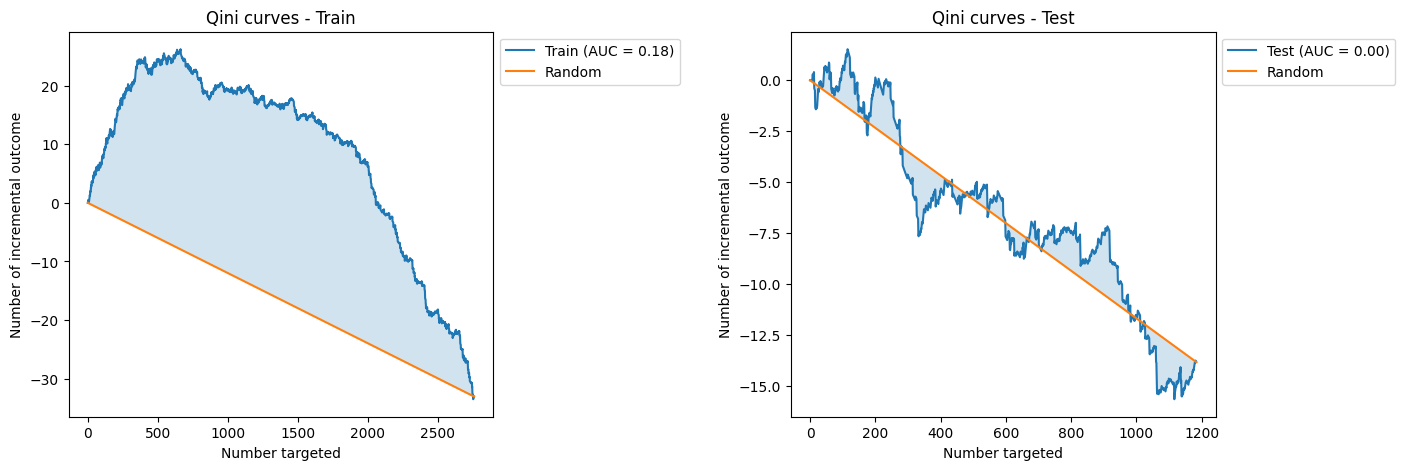

In [40]:
plot_qini_auc_best_parameters(full_data, 5, 40, 100)

# Hyperparameters S-learner

In [25]:
def hyperparameters_qini_auc_s_learner(full_data, reps, depths, min_samples, n_trees, max_samples):
    # depths = [3, 5, None, 20, 40]
    # min_samples = [5, 10, 20, 35, 50]
    # min_samples = [5]
    # n_trees = [24, 60, 100, 500, 1000, 2500]
    # n_trees = [24]
    # fig, ax = plt.subplots(3, 3, figsize=(20,20))

    output_raw = {}

    for dep in depths:
        for m_s in min_samples:
            for n_t in n_trees:
                for sam in max_samples:
                    output_raw[f"s_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"] = {"train": [], "test": []}

    for i in range(reps):
        if i % 5 == 0:
            print(f"Starting REP {i}")
        train, test = train_test_split(full_data, test_size=0.3)
        train_x = train.drop(columns=["W", "Y"])
        test_x = test.drop(columns=["W", "Y"])

        for dep in depths:
            for m_s in min_samples:
                for n_t in n_trees:
                    for sam in max_samples:
                        regr_s = RandomForestRegressor(max_depth=dep, min_samples_split=m_s, n_estimators=n_t, max_samples=sam)
                        regr_s.fit(train.drop(columns=["Y"]), train["Y"])

                        auc_train = qini_auc_score(y_true=train["Y"].to_list(), uplift=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})), treatment=train["W"].to_list())
                        auc_test = qini_auc_score(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list())

                        output_raw[f"s_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"]["train"].append(auc_train)
                        output_raw[f"s_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"]["test"].append(auc_test)

    output = {
        k: [np.mean(v["train"]), np.std(v["train"], ddof=1), np.mean(v["test"]), np.std(v["test"], ddof=1)]
        for k,v in output_raw.items()
    }
    out_dataframe = pd.DataFrame.from_dict(output, orient='index', columns=["AUC - train", "STD - train", "AUC - test", "STD - test"])
    out_dataframe = out_dataframe.sort_values("AUC - test", ascending=False)
    return out_dataframe

In [26]:
full_data_s = imp_xs.assign(W=w, Y=y)
chosen_variables_s = ["age", "urea", "platelets", "heart_rate", "pco2"]
full_data_s_2 = imp_xs[chosen_variables_s].assign(W=w, Y=y)
chosen_variables_s_2 = [v for v in columns_x if v not in chosen_variables_s]
full_data_s_3 = imp_xs[chosen_variables_s_2].assign(W=w, Y=y)

In [27]:
hyperparameters_qini_auc_s_learner(full_data_s, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])
# hyperparameters_qini_auc_s_learner(full_data, 2, depths=[3, 5, None, 20, 40], min_samples=[5], n_trees=[50], max_samples=[0.5, 1.0])

Starting REP 0
Starting REP 1
Starting REP 2
Starting REP 3
Starting REP 4
Starting REP 5
Starting REP 6
Starting REP 7
Starting REP 8
Starting REP 9
Starting REP 10
Starting REP 11
Starting REP 12
Starting REP 13
Starting REP 14
Starting REP 15
Starting REP 16
Starting REP 17
Starting REP 18
Starting REP 19


,AUC - train,STD - train,AUC - test,STD - test
s_learner_d=3_s=10_t=500_sam=1.0,0.069669,0.024633,0.038246,0.027320
s_learner_d=3_s=10_t=500_sam=0.5,0.083885,0.026062,0.036669,0.031722
s_learner_d=5_s=5_t=250_sam=1.0,0.159010,0.037961,0.036167,0.030607
s_learner_d=5_s=20_t=500_sam=0.5,0.141224,0.040086,0.034752,0.032452
s_learner_d=5_s=10_t=250_sam=0.5,0.161095,0.032291,0.033263,0.040892
...,...,...,...,...
s_learner_d=40_s=5_t=50_sam=1.0,0.439692,0.056104,0.000489,0.022937
s_learner_d=None_s=50_t=100_sam=0.5,0.170727,0.035053,0.000435,0.034610
s_learner_d=20_s=35_t=100_sam=1.0,0.311579,0.044502,0.000408,0.023241
s_learner_d=20_s=50_t=50_sam=1.0,0.217383,0.037466,-0.005356,0.042804


In [28]:
hyperparameters_qini_auc_s_learner(full_data_s_2, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])

Starting REP 0
Starting REP 1
Starting REP 2
Starting REP 3
Starting REP 4
Starting REP 5
Starting REP 6
Starting REP 7
Starting REP 8
Starting REP 9
Starting REP 10
Starting REP 11
Starting REP 12
Starting REP 13
Starting REP 14
Starting REP 15
Starting REP 16
Starting REP 17
Starting REP 18
Starting REP 19


,AUC - train,STD - train,AUC - test,STD - test
s_learner_d=40_s=50_t=50_sam=0.5,0.180325,0.024099,0.048599,0.018443
s_learner_d=40_s=20_t=100_sam=0.5,0.294375,0.025168,0.048328,0.027213
s_learner_d=None_s=50_t=250_sam=0.5,0.208038,0.017338,0.047935,0.029230
s_learner_d=None_s=35_t=500_sam=0.5,0.252078,0.019854,0.045791,0.026903
s_learner_d=40_s=50_t=500_sam=0.5,0.211970,0.016898,0.045643,0.028882
...,...,...,...,...
s_learner_d=3_s=5_t=50_sam=0.5,0.059416,0.032745,0.020419,0.035651
s_learner_d=3_s=20_t=100_sam=1.0,0.060719,0.027658,0.020390,0.036913
s_learner_d=None_s=5_t=100_sam=1.0,0.560835,0.023204,0.020112,0.034033
s_learner_d=3_s=35_t=50_sam=1.0,0.050951,0.025614,0.019619,0.033195


In [ ]:
hyperparameters_qini_auc_s_learner(full_data_s_3, 10, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])

# Hyperparameters T-learner

In [29]:
def hyperparameters_qini_auc_t_learner(full_data, reps, depths, min_samples, n_trees, max_samples):

    output_raw = {}

    for dep in depths:
        for m_s in min_samples:
            for n_t in n_trees:
                for sam in max_samples:
                    output_raw[f"t_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"] = {"train": [], "test": []}

    for i in range(reps):
        if i % 5 == 0:
            print(f"Starting REP {i}")
        train, test = train_test_split(full_data, test_size=0.3)
        train_x = train.drop(columns=["W", "Y"])
        test_x = test.drop(columns=["W", "Y"])

        for dep in depths:
            for m_s in min_samples:
                for n_t in n_trees:
                    for sam in max_samples:
                        regr0_t = RandomForestRegressor(max_depth=dep, min_samples_split=m_s, n_estimators=n_t, max_samples=sam)
                        regr1_t = RandomForestRegressor(max_depth=dep, min_samples_split=m_s, n_estimators=n_t, max_samples=sam)
                        regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
                        regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

                        auc_train = qini_auc_score(y_true=train["Y"].to_list(), uplift=(regr1_t.predict(train_x) - regr0_t.predict(train_x)).tolist(), treatment=train["W"].to_list())
                        auc_test = qini_auc_score(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list())

                        output_raw[f"t_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"]["train"].append(auc_train)
                        output_raw[f"t_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"]["test"].append(auc_test)

    output = {
        k: [np.mean(v["train"]), np.std(v["train"], ddof=1), np.mean(v["test"]), np.std(v["test"], ddof=1)]
        for k,v in output_raw.items()
    }
    out_dataframe = pd.DataFrame.from_dict(output, orient='index', columns=["AUC - train", "STD - train", "AUC - test", "STD - test"])
    out_dataframe = out_dataframe.sort_values("AUC - test", ascending=False)
    return out_dataframe

In [30]:
full_data_t = imp_xs.assign(W=w, Y=y)
chosen_variables_t = ["platelets", "age", "urea", "pco2", "driving_pressure"]
full_data_t_2 = imp_xs[chosen_variables_t].assign(W=w, Y=y)
chosen_variables_t_2 = [v for v in columns_x if v not in chosen_variables_t]
full_data_t_3 = imp_xs[chosen_variables_t_2].assign(W=w, Y=y)

In [31]:
hyperparameters_qini_auc_t_learner(full_data_t, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])
# hyperparameters_qini_auc_t_learner(full_data, 2, depths=[3, 5, None, 20, 40], min_samples=[5], n_trees=[50], max_samples=[0.5, 1.0])

Starting REP 0
Starting REP 1
Starting REP 2
Starting REP 3
Starting REP 4
Starting REP 5
Starting REP 6
Starting REP 7
Starting REP 8
Starting REP 9
Starting REP 10
Starting REP 11
Starting REP 12
Starting REP 13
Starting REP 14
Starting REP 15
Starting REP 16
Starting REP 17
Starting REP 18
Starting REP 19


,AUC - train,STD - train,AUC - test,STD - test
t_learner_d=3_s=50_t=100_sam=0.5,0.221988,0.017983,0.045891,0.029644
t_learner_d=3_s=5_t=250_sam=0.5,0.288289,0.019048,0.045537,0.028297
t_learner_d=3_s=35_t=100_sam=0.5,0.236171,0.021643,0.045204,0.027008
t_learner_d=3_s=5_t=500_sam=0.5,0.288208,0.017757,0.045162,0.029215
t_learner_d=5_s=35_t=50_sam=0.5,0.299758,0.019536,0.043156,0.024796
...,...,...,...,...
t_learner_d=None_s=5_t=250_sam=1.0,0.638331,0.010221,0.019073,0.027861
t_learner_d=None_s=5_t=50_sam=1.0,0.626164,0.013763,0.018992,0.025255
t_learner_d=20_s=10_t=250_sam=1.0,0.633401,0.012998,0.018920,0.035569
t_learner_d=40_s=10_t=250_sam=1.0,0.630192,0.013607,0.018343,0.031521


In [32]:
hyperparameters_qini_auc_t_learner(full_data_t_2, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])

Starting REP 0
Starting REP 1
Starting REP 2
Starting REP 3
Starting REP 4
Starting REP 5
Starting REP 6
Starting REP 7
Starting REP 8
Starting REP 9
Starting REP 10
Starting REP 11
Starting REP 12
Starting REP 13
Starting REP 14
Starting REP 15
Starting REP 16
Starting REP 17
Starting REP 18
Starting REP 19


,AUC - train,STD - train,AUC - test,STD - test
t_learner_d=40_s=50_t=50_sam=0.5,0.233782,0.010394,0.046343,0.026136
t_learner_d=20_s=50_t=100_sam=0.5,0.246555,0.011155,0.044841,0.028792
t_learner_d=40_s=50_t=500_sam=0.5,0.249717,0.009028,0.043835,0.027647
t_learner_d=20_s=50_t=50_sam=0.5,0.238679,0.013066,0.041399,0.032761
t_learner_d=None_s=50_t=500_sam=0.5,0.248405,0.007528,0.041230,0.028115
...,...,...,...,...
t_learner_d=20_s=5_t=250_sam=1.0,0.584911,0.014065,0.015872,0.024630
t_learner_d=None_s=10_t=50_sam=1.0,0.502516,0.014887,0.015424,0.024008
t_learner_d=40_s=5_t=250_sam=1.0,0.583472,0.014190,0.015406,0.024256
t_learner_d=20_s=5_t=100_sam=1.0,0.579135,0.013368,0.012884,0.018115


In [ ]:
hyperparameters_qini_auc_t_learner(full_data_t_3, 10, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])